In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Escalado de datos
from sklearn.preprocessing import StandardScaler
#PCA
from sklearn.decomposition import PCA

#Train_test_split
from sklearn.model_selection import train_test_split

#Metricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

#Regresion Lineal
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

#Validacion cruzada
from sklearn.model_selection import cross_val_score

#GridSearchCV
from sklearn.model_selection import GridSearchCV

#Bagging
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
url = '/content/drive/MyDrive/Data/properati.csv'

In [3]:
data = pd.read_csv(url)
data.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta


In [4]:
print('El data set de inicio tiene',data.shape[0], ' filas y', data.shape[1], 'columnas')

El data set de inicio tiene 146660  filas y 19 columnas


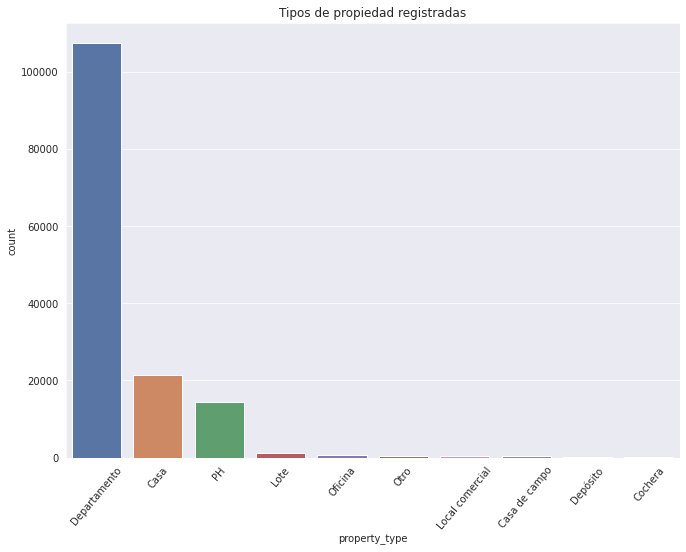

In [5]:
sns.set({'figure.figsize':(11,8)})
plt.xticks(rotation=50)
plt.title('Tipos de propiedad registradas')
sns.countplot(
    data = data,
    x = "property_type",
    order = data['property_type'].value_counts().index
)

3 tipos de propiedad predominan los registros, siendo Departamento el tipo de propiedad que presenta mayor registros

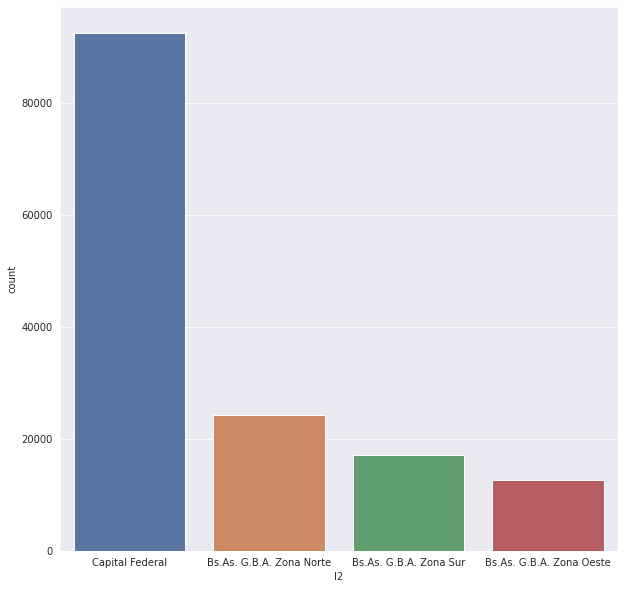

In [6]:
#Grafico de Regiones registradas en l2
plt.rcParams['figure.figsize']=(10,10)
sns.countplot(x='l2', data=data, order = data['l2'].value_counts().index)

Con base en el grafico la region que predomina en los registros de propiedad es Capital Federal

In [7]:
#Filtrado de Datos
data_ml=data[(data.l2 == 'Capital Federal') & (data.property_type.isin(['Departamento', 'Casa', 'PH']))]
data_ml = data_ml[(data_ml.surface_total >= 15)] 
data_ml = data_ml[(data_ml.surface_total <= 1000)]
data_ml = data_ml[(data_ml.price <= 4000000 )]  
data_ml = data_ml[['l3','property_type','rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']]

In [8]:
print('El dataset filtrado contiene',data_ml.shape[0], ' filas y', data_ml.shape[1], 'columnas')

El dataset filtrado contiene 82373  filas y 7 columnas


In [9]:
#Valores nulos
def valores_nulos(data):
  print('Porcentaje de valores nulos')
  print(data.isnull().sum() / data.shape[0] * 100)

In [10]:
valores_nulos(data_ml)

Porcentaje de valores nulos
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.068311
surface_total      0.000000
surface_covered    0.627633
price              0.000000
dtype: float64


In [11]:
#Compruebo la presencia de valores invertidos en columnas surface
datos_invertidos= data_ml.loc[data_ml.surface_total < data_ml.surface_covered]
print('Existen', len(datos_invertidos),'datos invertidos')

Existen 751 datos invertidos


In [12]:
#Filtrado de datos invertidos
data_ml = data_ml[(data_ml.surface_total >= data_ml.surface_covered)] 

In [13]:
#Comprobar valores nulos con el nuevo filtrado
valores_nulos(data_ml)

Porcentaje de valores nulos
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.022132
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


In [14]:
#Realizo una copia que mas adelante se empleara
data_2 = data_ml.copy()

In [15]:
#Limpieza de valores nulos
data_ml.dropna(axis=0, inplace=True)
#Reset de index
data_ml.reset_index(drop=True, inplace=True)

In [16]:
valores_nulos(data_ml)

Porcentaje de valores nulos
l3                 0.0
property_type      0.0
rooms              0.0
bathrooms          0.0
surface_total      0.0
surface_covered    0.0
price              0.0
dtype: float64


## Outliers

Text(0.5, 1.0, 'Outliers en Price')

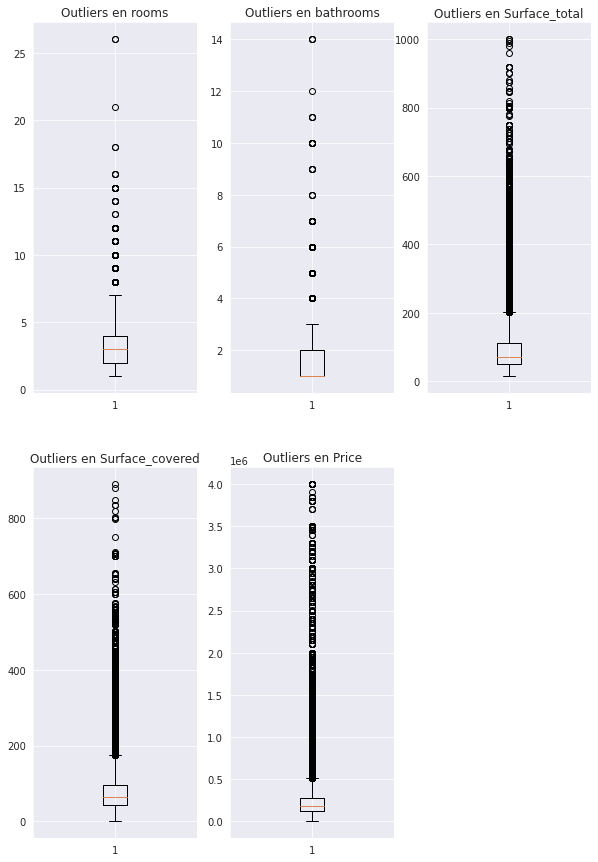

In [17]:
figura = plt.figure(figsize=(10,15))
ax1 = figura.add_subplot(2,3,1)
ax2 = figura.add_subplot(2,3,2)
ax3 = figura.add_subplot(2,3,3)
ax4 = figura.add_subplot(2,3,4)
ax5 = figura.add_subplot(2,3,5)

ax1.boxplot(data_ml['rooms'])
ax1.set_title('Outliers en rooms')

ax2.boxplot(data_ml['bathrooms'])
ax2.set_title('Outliers en bathrooms')

ax3.boxplot(data_ml['surface_total'])
ax3.set_title('Outliers en Surface_total')

ax4.boxplot(data_ml['surface_covered'])
ax4.set_title('Outliers en Surface_covered')

ax5.boxplot(data_ml['price'])
ax5.set_title('Outliers en Price')

In [18]:
'''Limpieza de outliers'''
def limpiar_dataframe(dataframe, columna):
    q25, q75 = np.percentile(dataframe[columna], [25, 75])
    iqr = q75 - q25
    if (q25 -(1.5 * iqr)) < 0:
        IQMenor = 0.0
    else:
        IQMenor = float(q25 - (1.5 * iqr))

    IQMayor = float(q75 + (1.5 * iqr))
    
    dataframe = dataframe[(dataframe[columna] > IQMenor ) &
        (dataframe[columna] < IQMayor)]
    
    return dataframe

In [19]:
data_columnas = ['rooms','bathrooms','surface_total','surface_covered','price']
for i in data_columnas:
    data_ml = limpiar_dataframe(data_ml,i)
data_ml.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Outliers en Price')

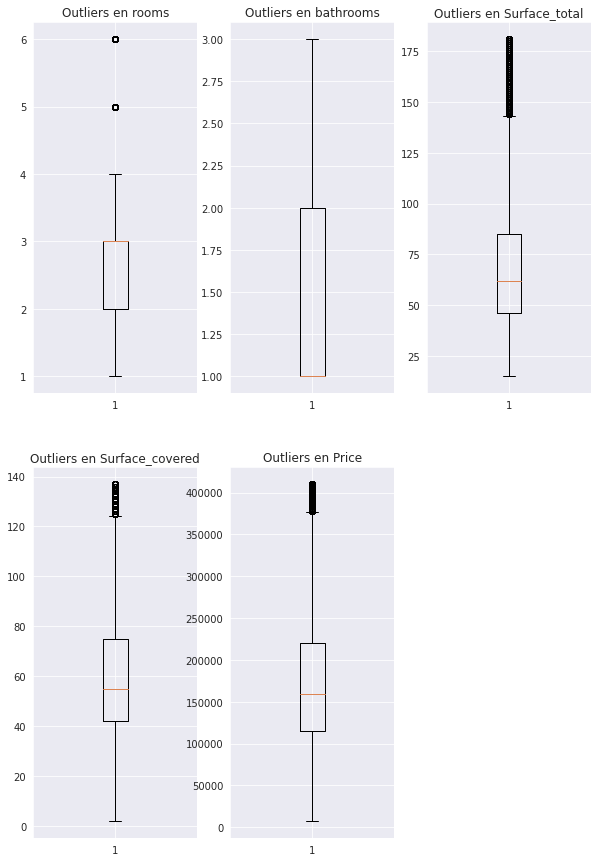

In [20]:
#Presencia de Outliers
figura = plt.figure(figsize=(10,15))
ax1 = figura.add_subplot(2,3,1)
ax2 = figura.add_subplot(2,3,2)
ax3 = figura.add_subplot(2,3,3)
ax4 = figura.add_subplot(2,3,4)
ax5 = figura.add_subplot(2,3,5)

ax1.boxplot(data_ml['rooms'])
ax1.set_title('Outliers en rooms')

ax2.boxplot(data_ml['bathrooms'])
ax2.set_title('Outliers en bathrooms')

ax3.boxplot(data_ml['surface_total'])
ax3.set_title('Outliers en Surface_total')

ax4.boxplot(data_ml['surface_covered'])
ax4.set_title('Outliers en Surface_covered')

ax5.boxplot(data_ml['price'])
ax5.set_title('Outliers en Price')

# Imputacion de valores faltantes

Para la imputacion de valores faltantes, empleare el dataset "data_ml" ya que este no cuenta con valores nulos, duplicados o valores atipicos. Imputare los valores faltantes de mi dataset "data_2" empleando la media obtenia segun las variables seleccionadas de mi "data_ml"

In [21]:
#Valores nulos en data_2
valores_nulos(data_2)

Porcentaje de valores nulos
l3                 0.000000
property_type      0.000000
rooms              0.000000
bathrooms          1.022132
surface_total      0.000000
surface_covered    0.000000
price              0.000000
dtype: float64


In [22]:
#Obtengo la media de bathrooms en funcion de tipo de propiedad
mean_bt = data_ml.groupby('property_type')['bathrooms'].mean().round(0)
#Converion a diccionario
mean_bt = dict(round(mean_bt))
mean_bt

{'Casa': 2.0, 'Departamento': 1.0, 'PH': 1.0}

In [23]:
#Imputacion de valores nulos
data_2.bathrooms = data_2.bathrooms.fillna(data_2.property_type.map(mean_bt))

In [24]:
valores_nulos(data_2)

Porcentaje de valores nulos
l3                 0.0
property_type      0.0
rooms              0.0
bathrooms          0.0
surface_total      0.0
surface_covered    0.0
price              0.0
dtype: float64


# Outliers

Ya que no cuento con valores nulos, realizo la elimiación de valores atipicos en mi dataset de trabajo "data_2"

In [25]:
data_columnas = ['rooms','bathrooms','surface_total','surface_covered','price']
for i in data_columnas:
    data_2 = limpiar_dataframe(data_2,i)
data_2.reset_index(drop=True, inplace=True)

# Valores duplicados

In [26]:
#Elimino valores duplicados 
data_ml.drop_duplicates(inplace=True)
data_2.drop_duplicates(inplace=True)
#Reset Index
data_ml.reset_index(drop=True, inplace=True)
data_ml.reset_index(drop=True, inplace=True)

# Encoding variables categoricas

In [27]:
#Tipos de propiedad
columna = ['property_type']

for var in columna:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data_2[var], prefix=var)
    data_2=data_2.join(cat_list)

#Elimino la columna encodeada
data_2.drop(columns='property_type', inplace=True)
data_2.reset_index(drop=True, inplace=True)

In [28]:
data_2.head(2)

,l3,rooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH
0,Boedo,2.0,2.0,70.0,58.0,159000.0,0,0,1
1,Palermo,2.0,1.0,45.0,45.0,125000.0,0,0,1


In [29]:
#Columna l3
l3_get = pd.get_dummies(data_2['l3'])
#Concateno el dataframe obtenido con mi dataframe de trabajo
data_2 = pd.concat([data_2, l3_get], axis=1)

#Elimino las columna encodeadas
data_2.drop(columns=['l3',], inplace=True)
data_2.head(2)

,rooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
0,2.0,2.0,70.0,58.0,159000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2.0,1.0,45.0,45.0,125000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Datos en X e Y

In [30]:
X = data_2.drop(['price'], axis=1)
y = data_2[['price']]

# Escalado de datos

In [31]:
#Separo las variables a escalar
data_escalado = X[['rooms', 'bathrooms', 'surface_total','surface_covered']]

In [32]:
std = StandardScaler()
std.fit(data_escalado)
data_escalado_nueva = std.transform(data_escalado)

data_escalado_nueva = pd.DataFrame(data=data_escalado_nueva,
                     columns=['rooms', 'bathrooms','surface_covered','surface_total'])

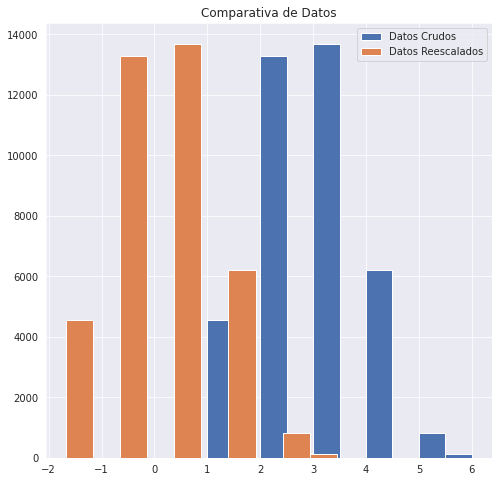

In [33]:
#Visualizo la comparacion entre los datos crudos y los datos escalados
plt.figure(figsize=(8,8))
data_escalado.rooms.hist(label = 'Datos Crudos')
data_escalado_nueva.rooms.hist(label = 'Datos Reescalados')
plt.title('Comparativa de Datos')
plt.legend()
plt.show()

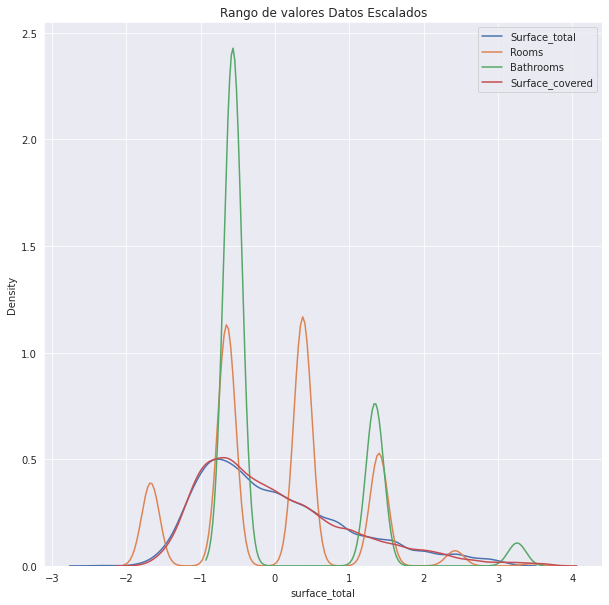

In [34]:
sns.kdeplot((data_escalado_nueva['surface_total']), label='Surface_total')
sns.kdeplot((data_escalado_nueva['rooms']), label='Rooms')
sns.kdeplot((data_escalado_nueva['bathrooms']), label='Bathrooms')
sns.kdeplot((data_escalado_nueva['surface_covered']), label='Surface_covered')
plt.title('Rango de valores Datos Escalados')
plt.legend()

In [35]:
#Variable Price
std.fit_transform(y)
y = pd.DataFrame(data=y, columns=['price'])

In [36]:
data_escalado_nueva.shape, y.shape

((38676, 4), (38676, 1))

In [37]:
#Concateno mis datos Escalados con los valores de los Barrios encodeados
X_escalada = pd.concat([data_escalado_nueva,l3_get], axis=1, join='inner')

In [38]:
X_escalada.shape, y.shape

((38676, 61), (38676, 1))

In [39]:
X_escalada.head(2)

,rooms,bathrooms,surface_covered,surface_total,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
0,-0.64799,1.345108,0.026062,-0.097188,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.64799,-0.566673,-0.793589,-0.631702,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# PCA

In [40]:
#Realizo un for para comprobar mi mejor numero de n_components

for i in range(1,40,2):

    pca = PCA(n_components=i, random_state=40)

    X_nuevo = pca.fit_transform(X_escalada)

    print('n_components=:', i,'varianza:', pca.explained_variance_ratio_.sum())

n_components=: 1 varianza: 0.6098487145540953
n_components=: 3 varianza: 0.7890084278084152
n_components=: 5 varianza: 0.8296612400156784
n_components=: 7 varianza: 0.8600641141178671
n_components=: 9 varianza: 0.8821590192885784
n_components=: 11 varianza: 0.9009144330228638
n_components=: 13 varianza: 0.915209607962755
n_components=: 15 varianza: 0.9262574109887318
n_components=: 17 varianza: 0.9340993008874827
n_components=: 19 varianza: 0.9409613761565486
n_components=: 21 varianza: 0.9470728928466582
n_components=: 23 varianza: 0.9522729804065561
n_components=: 25 varianza: 0.9569115379900984
n_components=: 27 varianza: 0.9615035374074368
n_components=: 29 varianza: 0.9657652656593785
n_components=: 31 varianza: 0.9696896709617121
n_components=: 33 varianza: 0.9734601012175631
n_components=: 35 varianza: 0.9770413215873069
n_components=: 37 varianza: 0.9803953078338573
n_components=: 39 varianza: 0.9834636632131463


In [41]:
pca = PCA(n_components=25, random_state=42)
X_PCA = pca.fit_transform(X_escalada)
X_PCA = pd.DataFrame(data=X_PCA)

# Modelo Benchmark

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [43]:
arbol = DecisionTreeRegressor()

In [44]:
def evaluar_modelo(modelo,X_train,X_test,y_train,y_test):
    modelo.fit(X_train,y_train)
    print ("--> R2 del modelo  en train:", modelo.score(X_train,y_train) )
    print('RMSE en train:',np.sqrt(mean_squared_error(y_train, modelo.predict(X_train))))
    print ("--> R2 del modelo en test:", modelo.score(X_test,y_test) )
    print('RMSE en test:',np.sqrt(mean_squared_error(y_test, modelo.predict(X_test))))

In [45]:
evaluar_modelo(arbol, X_train, X_test, y_train, y_test)

--> R2 del modelo  en train: 0.9653013146880172
RMSE en train: 14804.811938160778
--> R2 del modelo en test: 0.6667207600730929
RMSE en test: 46265.38379801007


# Regresion lineal

In [46]:
reg = LinearRegression()

In [47]:
evaluar_modelo(reg, X_train, X_test, y_train, y_test)

--> R2 del modelo  en train: 0.6867000906889332
RMSE en train: 44486.32389097013
--> R2 del modelo en test: 0.6857177454393755
RMSE en test: 44927.47054696162


Ya que el R2 de mi modelo de Regresion Lineal no es muy bueno, empleo PolynomialFeatures para ver si esta metrica mejora

## Polynomial Features
Aplico Polynomial Features obre mis datos provenientes de PCA

In [48]:
#Defino y entreno el modelo
poly = PolynomialFeatures(2, include_bias=False) 
X_pol = poly.fit_transform(X_PCA)

In [49]:
X_train_new,X_test_new,y_train,y_test = train_test_split(X_pol,y, test_size=0.30, random_state=40)
evaluar_modelo(reg, X_train_new, X_test_new, y_train, y_test)

--> R2 del modelo  en train: 0.7701094648529752
RMSE en train: 38269.01358626998
--> R2 del modelo en test: 0.7642536734710397
RMSE en test: 38528.760858842696


## Ridge

In [50]:
alpha = [1, 0.5, 0.1 ,0.01, 0.005, 0.001, 0.0001]

for i in alpha:
    reg_ridge = Ridge(alpha= i)
    print('Valor de alpha:', i)
    evaluar_modelo(reg_ridge, X_train_new, X_test_new, y_train, y_test)
    print('....................')

Valor de alpha: 1
--> R2 del modelo  en train: 0.7279980946333662
RMSE en train: 41626.76829220369
--> R2 del modelo en test: 0.7281379762176265
RMSE en test: 41374.88954451957
....................
Valor de alpha: 0.5
--> R2 del modelo  en train: 0.7296501171321726
RMSE en train: 41500.16422791996
--> R2 del modelo en test: 0.7293616109950813
RMSE en test: 41281.6715772805
....................
Valor de alpha: 0.1
--> R2 del modelo  en train: 0.7366830867530938
RMSE en train: 40956.80780679825
--> R2 del modelo en test: 0.7347598616708109
RMSE en test: 40867.888279894716
....................
Valor de alpha: 0.01
--> R2 del modelo  en train: 0.7539193336470716
RMSE en train: 39593.64360444006
--> R2 del modelo en test: 0.7493077435944998
RMSE en test: 39731.32369065865
....................
Valor de alpha: 0.005
--> R2 del modelo  en train: 0.7585078444396127
RMSE en train: 39222.76776219455
--> R2 del modelo en test: 0.7534496685482422
RMSE en test: 39401.73719380951
....................

## Lasso

In [51]:
#Empleo un for para comprobar que numero en alpha me arroja mejor R2'''
alpha = [1, 0.5, 0.1 ,0.01, 0.005, 0.001, 0.0001]

for i in alpha:
    reg_lasso = Lasso(alpha= i)
    print('Valor de alpha:', i)
    evaluar_modelo(reg_lasso, X_train_new, X_test_new, y_train, y_test)
    print('....................')

Valor de alpha: 1
--> R2 del modelo  en train: 0.7362943575606054
RMSE en train: 40987.02849213962
--> R2 del modelo en test: 0.7341401901324756
RMSE en test: 40915.59956017287
....................
Valor de alpha: 0.5
--> R2 del modelo  en train: 0.7388802377454752
RMSE en train: 40785.575363684824
--> R2 del modelo en test: 0.736302226431963
RMSE en test: 40748.892164437086
....................
Valor de alpha: 0.1
--> R2 del modelo  en train: 0.7414397480464965
RMSE en train: 40585.19188317541
--> R2 del modelo en test: 0.7385316767650172
RMSE en test: 40576.269420333265
....................
Valor de alpha: 0.01
--> R2 del modelo  en train: 0.7424832301900686
RMSE en train: 40503.213432371325
--> R2 del modelo en test: 0.739588561178717
RMSE en test: 40494.179456408885
....................
Valor de alpha: 0.005
--> R2 del modelo  en train: 0.7425581748363324
RMSE en train: 40497.31921450818
--> R2 del modelo en test: 0.739650971201707
RMSE en test: 40489.32676230349
..................

Ridge optime un mejor score de R2 sobre los datos de Test, por lo que empleo este modelo para realizar una busqueda de sus mejores hyperparametros

## Validación cruzada

In [52]:
reg_ridge = Ridge(alpha=0.0001)
ridge_scores = cross_val_score(reg_ridge, X_pol, y, cv=5)
print(ridge_scores)
print("Accuracy para Ridge: %0.2f (+/- %0.2f)" % (ridge_scores.mean(), ridge_scores.std() * 2))

[0.76235813 0.76894935 0.76503978 0.75375133 0.76865319]
Accuracy para Ridge: 0.76 (+/- 0.01)


Al realizar validacion cruzada, se demuestra que el rendimiento del modelo empleado no depende de la partición de los datos.

## Curva de validacón con validación cruzada

In [53]:
from sklearn.model_selection import cross_validate
reg_train_scores_mean = []
reg_train_scores_std = []
reg_test_scores_mean = []
reg_test_scores_std = []

alpha = [1, 0.5, 0.1 ,0.01, 0.005, 0.001, 0.0001]

for i in alpha:
    reg_ridge = Ridge(alpha= i)
    ridge_scores = cross_validate(reg_ridge, X_pol, y, cv=5, return_train_score=True, n_jobs = -1)
    
    reg_train_scores_mean.append(ridge_scores['train_score'].mean())
    reg_train_scores_std.append(ridge_scores['train_score'].std())
    
    reg_test_scores_mean.append(ridge_scores['test_score'].mean())
    reg_test_scores_std.append(ridge_scores['test_score'].std())

reg_train_scores_mean = np.array(reg_train_scores_mean)
reg_train_scores_std = np.array(reg_train_scores_std)
reg_test_scores_mean = np.array(reg_test_scores_mean)
reg_test_scores_std = np.array(reg_test_scores_std)

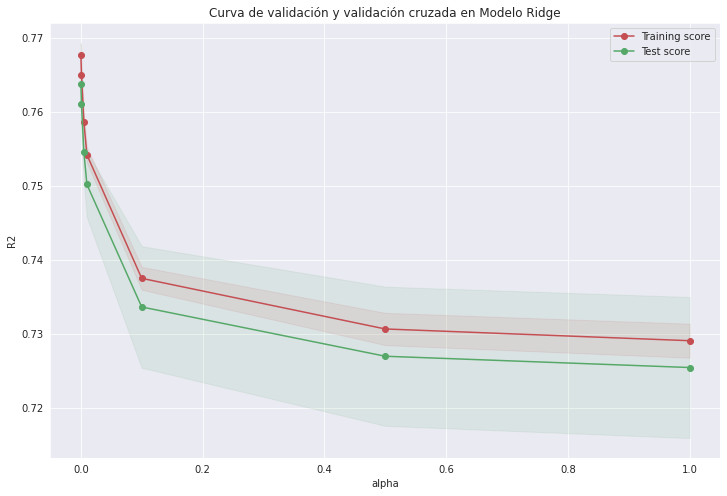

In [54]:
plt.figure(figsize=(12,8))
plt.fill_between(alpha, reg_train_scores_mean - reg_train_scores_std,
                 reg_train_scores_mean + reg_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(alpha, reg_test_scores_mean - reg_test_scores_std,
                 reg_test_scores_mean + reg_test_scores_std, alpha=0.1, color="g")
plt.plot(alpha, reg_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(alpha, reg_test_scores_mean, 'o-', color="g",
         label="Test score")
plt.legend()
plt.title('Curva de validación y validación cruzada en Modelo Ridge')
plt.ylabel('R2')
plt.xlabel('alpha')
plt.show()

## GridSearchCV Ridge

In [55]:
param_dist = {
    'alpha':[0.0001],
    'normalize': [False,True],
    'fit_intercept': [False,True],
    'solver' : ['auto', 'lsqr' , 'cholesky'],
    'max_iter': np.arange(1,50,5),
    'random_state': np.arange(1,50,5)
}

model = GridSearchCV(reg_ridge, param_grid=param_dist, cv=5)
model.fit(X_train_new,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=0.0001, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001], 'fit_intercept': [False, True],
                         'max_iter': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'normalize': [False, True],
                         'random_state': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'solver': ['auto', 'lsqr', 'cholesky']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
print("Mejores parametros : "+str(model.best_params_))
print("Mejor Score : "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores.head(2)

Mejores parametros : {'alpha': 0.0001, 'fit_intercept': True, 'max_iter': 1, 'normalize': False, 'random_state': 1, 'solver': 'auto'}
Mejor Score : 0.764933343962831



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_normalize,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.189735,0.005613,0.006096,0.000468,0.0001,False,1,False,1,auto,"{'alpha': 0.0001, 'fit_intercept': False, 'max...",0.772696,0.753812,0.767483,0.763272,0.766166,0.764686,0.006236,201
1,0.076826,0.007026,0.006027,0.000347,0.0001,False,1,False,1,lsqr,"{'alpha': 0.0001, 'fit_intercept': False, 'max...",-2.193792,-2.197276,-2.172391,-2.118944,-2.133956,-2.163272,0.031608,1181


In [57]:
#Convierto a DataFrame mis datos
X_train_new = pd.DataFrame(data=X_train_new)
X_test_new = pd.DataFrame(data=X_test_new)

In [58]:
#Tomo una muestra de mis datos en Test
idxs = np.random.randint(X_test_new.shape[0], size=10)
idxs

array([ 5568,  8757,  3207,  6877,  5584,  5172,  2996, 10146,  3440,
        4935])

In [59]:
muestra = X_test_new.iloc[idxs]
prediccion = model.predict(muestra)
prediccion

array([[189020.8752967 ],
       [201191.4042984 ],
       [143198.13268222],
       [ 80595.44968921],
       [110835.64100929],
       [307791.22579897],
       [117035.45485449],
       [132703.37933669],
       [129310.87934288],
       [143264.09993933]])

In [60]:
valor_data = []
for i in idxs:
    valor_real = y_test.price.iloc[i]
    valor_data.append(valor_real)

In [61]:
valor_data = pd.DataFrame((valor_data), columns = ['valor_real'])
prediccion = pd.DataFrame((prediccion), columns = ['valor_predicho'])
comparacion = pd.merge(valor_data, prediccion, right_index=True, left_index=True)
comparacion

,valor_real,valor_predicho
0,240000.0,189020.875297
1,170000.0,201191.404298
2,168000.0,143198.132682
3,95000.0,80595.449689
4,92000.0,110835.641009
5,356000.0,307791.225799
6,118000.0,117035.454854
7,90000.0,132703.379337
8,114500.0,129310.879343
9,127030.0,143264.099939


Text(0, 0.5, 'Precio')

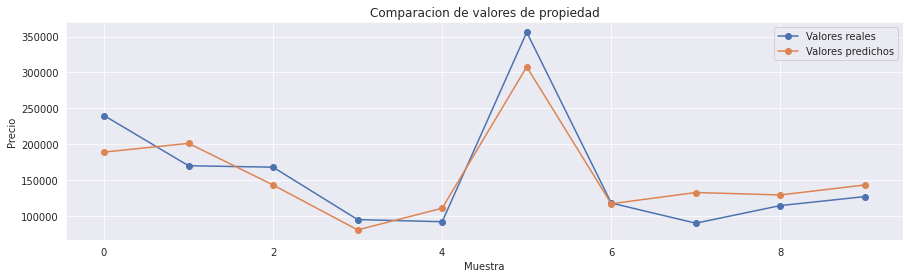

In [62]:
r = comparacion['valor_real']
p = comparacion['valor_predicho']
plt.figure(figsize=(15,4))
plt.plot(r,'o-',label='Valores reales')
plt.plot(p,'o-',label='Valores predichos')
plt.legend()
plt.title('Comparacion de valores de propiedad')
plt.xlabel('Muestra')
plt.ylabel('Precio')

# Bagging

Para esta sección empleare los data en donde se encuentran los datos escalados y encodeados

In [63]:
X_escalada.head(2)

,rooms,bathrooms,surface_covered,surface_total,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
0,-0.64799,1.345108,0.026062,-0.097188,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.64799,-0.566673,-0.793589,-0.631702,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_escalada, y, test_size=0.30, random_state=42)

In [65]:

estimator = [10,30,50,80,100]

for i in estimator:
    reg_bgg = BaggingRegressor(base_estimator=KNeighborsRegressor(),
                           n_estimators=i, bootstrap_features=True)
    print('Numero de estimators:', i)
    reg_bgg.fit(X_train, y_train)
    print ("R2 of KNeighborsRegressor test:", reg_bgg.score(X_test,y_test) )
    print('RMSE train:',np.sqrt(mean_squared_error(y_test, reg_bgg.predict(X_test))))
    print('-------------------------------')

Numero de estimators: 10
R2 of KNeighborsRegressor test: 0.7356136251830205
RMSE train: 41207.05460367884
-------------------------------
Numero de estimators: 30
R2 of KNeighborsRegressor test: 0.7649669672442196
RMSE train: 38852.278255152894
-------------------------------
Numero de estimators: 50
R2 of KNeighborsRegressor test: 0.7647688540602228
RMSE train: 38868.649416114
-------------------------------
Numero de estimators: 80
R2 of KNeighborsRegressor test: 0.7670328394054462
RMSE train: 38681.151259740334
-------------------------------
Numero de estimators: 100
R2 of KNeighborsRegressor test: 0.7623714930998258
RMSE train: 39066.21247194156
-------------------------------


In [66]:
reg_bgg = BaggingRegressor(base_estimator=KNeighborsRegressor(),
                           n_estimators=80, bootstrap_features=True)

## Validación cruzada

In [67]:
bgg_scores = cross_val_score(reg_bgg, X_escalada, y, cv = 5)

In [68]:
print(bgg_scores)
print("Accuracy para Baggin: %0.2f (+/- %0.2f)" % (bgg_scores.mean(), bgg_scores.std() * 2))

[0.76779692 0.76352336 0.76168075 0.75110627 0.76761464]
Accuracy para Baggin: 0.76 (+/- 0.01)


In [69]:
reg_bgg.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                                                    metric_params=None,
                                                    n_jobs=None, n_neighbors=5,
                                                    p=2, weights='uniform'),
                 bootstrap=True, bootstrap_features=True, max_features=1.0,
                 max_samples=1.0, n_estimators=80, n_jobs=None, oob_score=False,
                 random_state=None, verbose=0, warm_start=False)

In [70]:
#Tomo una muestra de mi Datos en Test
idxs = np.random.randint(X_test.shape[0], size=10)
idxs

array([1201,  449, 9627,  372, 9949, 3269, 5922, 6363, 2520, 8175])

In [71]:
muestra = X_test.iloc[idxs]
prediccion = reg_bgg.predict(muestra)
valor_data = []
for i in idxs:
    valor_real = y_test.price.iloc[i]
    valor_data.append(valor_real)

In [72]:
valor_data = pd.DataFrame((valor_data), columns = ['valor_real'])
prediccion = pd.DataFrame((prediccion), columns = ['valor_predicho'])
comparacion = pd.merge(valor_data, prediccion, right_index=True, left_index=True)
comparacion

,valor_real,valor_predicho
0,115000.0,115048.0050
1,105000.0,120316.1950
2,350000.0,319451.7200
3,173000.0,124762.3250
4,260000.0,252729.6575
5,78000.0,107342.5000
6,230000.0,142323.0125
7,105000.0,93564.6925
8,136000.0,99184.1300
9,50000.0,72435.4850


Text(0, 0.5, 'Precio')

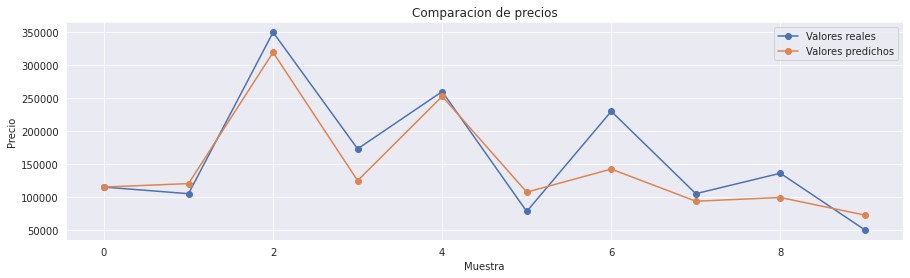

In [73]:
r = comparacion['valor_real']
p = comparacion['valor_predicho']
plt.figure(figsize=(15,4))
plt.plot(r,'o-',label='Valores reales')
plt.plot(p,'o-',label='Valores predichos')
plt.legend()
plt.title('Comparacion de precios')
plt.xlabel('Muestra')
plt.ylabel('Precio')